# Bayesian pooled voting intention (Using PyMC)
- national primary voting intention
- monthly dirichlet model 
- early and exploratory

## Set-up

In [1]:
# system imports
from pathlib import Path
from typing import Any, NotRequired, TypedDict

# analytic imports
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import arviz as az  # type: ignore[import-untyped]
import pymc as pm  # type: ignore[import-untyped]
import pytensor  # type: ignore[import-untyped]
import pytensor.tensor as pt  # type: ignore[import-untyped]
from IPython.display import display

In [2]:
# local import
import bayes_tools
import plotting
from common import (
    MIDDLE_DATE,
    VOTING_INTENTION,
    ensure,
    NSW,
    VIC,
    QLD,
    SA,
    WA,
    TAS,
    NT,
    ACT,
)
from data_capture import retrieve

In [3]:
# plotting related
plt.rcParams.max_subplots = 40

SHOW = False  # show charts in the notebook

# model diagram
MODEL_DIR = "../model-images/"
Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)

### Check operating environment

In [4]:
%load_ext watermark
%watermark --python --machine --conda --iversions --watermark

Python implementation: CPython
Python version       : 3.12.9
IPython version      : 8.32.0

conda environment: pymc

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

pymc      : 5.20.1
matplotlib: 3.10.0
pandas    : 2.2.3
numpy     : 1.26.4
pytensor  : 2.27.1
arviz     : 0.20.0
IPython   : 8.32.0

Watermark: 2.5.0



## Get data

In [5]:
def get_data():
    """Retrieve data after running the data capture notebook."""

    retrieved = retrieve()
    ensure(retrieved, "You must run the data capture notebook every day.")
    return retrieved


raw_data = get_data()

## National Monthly Primary Voting Intention Model

In [6]:
def prepare_nat_vi(input_data: dict[str, pd.DataFrame]) -> pd.DataFrame:
    """Construct the national primary voting intention data
    as an array of simplex values."""

    data = input_data[VOTING_INTENTION]
    data = plotting.amalgamate_other(data)
    data.index = data[MIDDLE_DATE]
    data = data.sort_index(ascending=True)
    keep = [
        "Brand",
        "Primary vote L/NP",
        "Primary vote ALP",
        "Primary vote GRN",
        "Primary vote Other",
    ]
    parties = keep[1:]
    data = data[keep]
    data = data[data.isna().sum(axis=1) == 0]
    data[parties] = data[parties] / 100.0  # convert to simplex
    row_sum = data[parties].sum(axis=1)
    for party in parties:
        data[party] = data[party] / row_sum  # norm the rows

    return data


def get_parameters(input_data: dict[str, pd.DataFrame]) -> dict[str, Any]:
    """Return a dictionary of parameters for the model."""

    simplex_nat_vi = prepare_nat_vi(input_data)
    y = simplex_nat_vi[simplex_nat_vi.columns[-4:]].to_numpy()
    start = y[:10].mean(axis=0)  # start with the first 10 observations
    pollsters = simplex_nat_vi["Brand"].unique()
    pollster_map = {pollster: i for i, pollster in enumerate(pollsters)}
    brand = simplex_nat_vi["Brand"].map(pollster_map).to_numpy()
    periods = pd.PeriodIndex(simplex_nat_vi.index, freq="M")
    month = np.array([m.n for m in (periods - periods.min())])

    return {
        # polling data
        "simplex_nat_vi": simplex_nat_vi,
        "y": y.tolist(),
        "pollsters": pollsters,
        "pollster_map": pollster_map,
        "brand": brand,
        "periods": periods,
        "month": month,
        "start": start,
        # other
        "conc": 7_500,  # higher value => more concentration
        # sizes
        "n_months": month.max() + 1,
        "n_polls": len(simplex_nat_vi),
        "n_parties": y.shape[1],
    }


P = get_parameters(raw_data)
P["y"][-1]  # check the last row of the polling data

[0.405, 0.29, 0.11, 0.195]

## Build Model

In [7]:
def build_model() -> pm.Model:
    """Build the model for the national primary voting intention."""

    model = pm.Model()
    with model:

        # temporal model for monthly voting intention
        vi = []
        for i in range(P["n_months"]):
            if not i:
                a = P["start"]
            else:
                a = vi[i - 1]
            vi.append(
                pm.Dirichlet(f"vi_{i:02}", a=a * P["conc"], shape=(P["n_parties"],))
            )
        vi_stack = pm.Deterministic("vi_stack", pm.math.stack(vi, axis=1))

        # likelihood / observation model
        for i in range(P["n_polls"]):
            P["y"][i] = pm.Dirichlet(
                f"y_{i:03}",
                a=vi_stack[:, P["month"][i]] * P["conc"],
                observed=P["y"][i],
            )

    return model


model = build_model()

## Fit the data to the model

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

/Users/bryanpalmer/micromamba/envs/pymc/lib/python3.12/site-packages/jax/_src/interpreters/mlir.py:1114: UserWarning: Some donated buffers were not usable: ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(

Max r_hat: 1.0
Min ess: 2617.0
Divergences: 0


(Inference data with groups:
 	> posterior
 	> sample_stats
 	> observed_data,
 '')

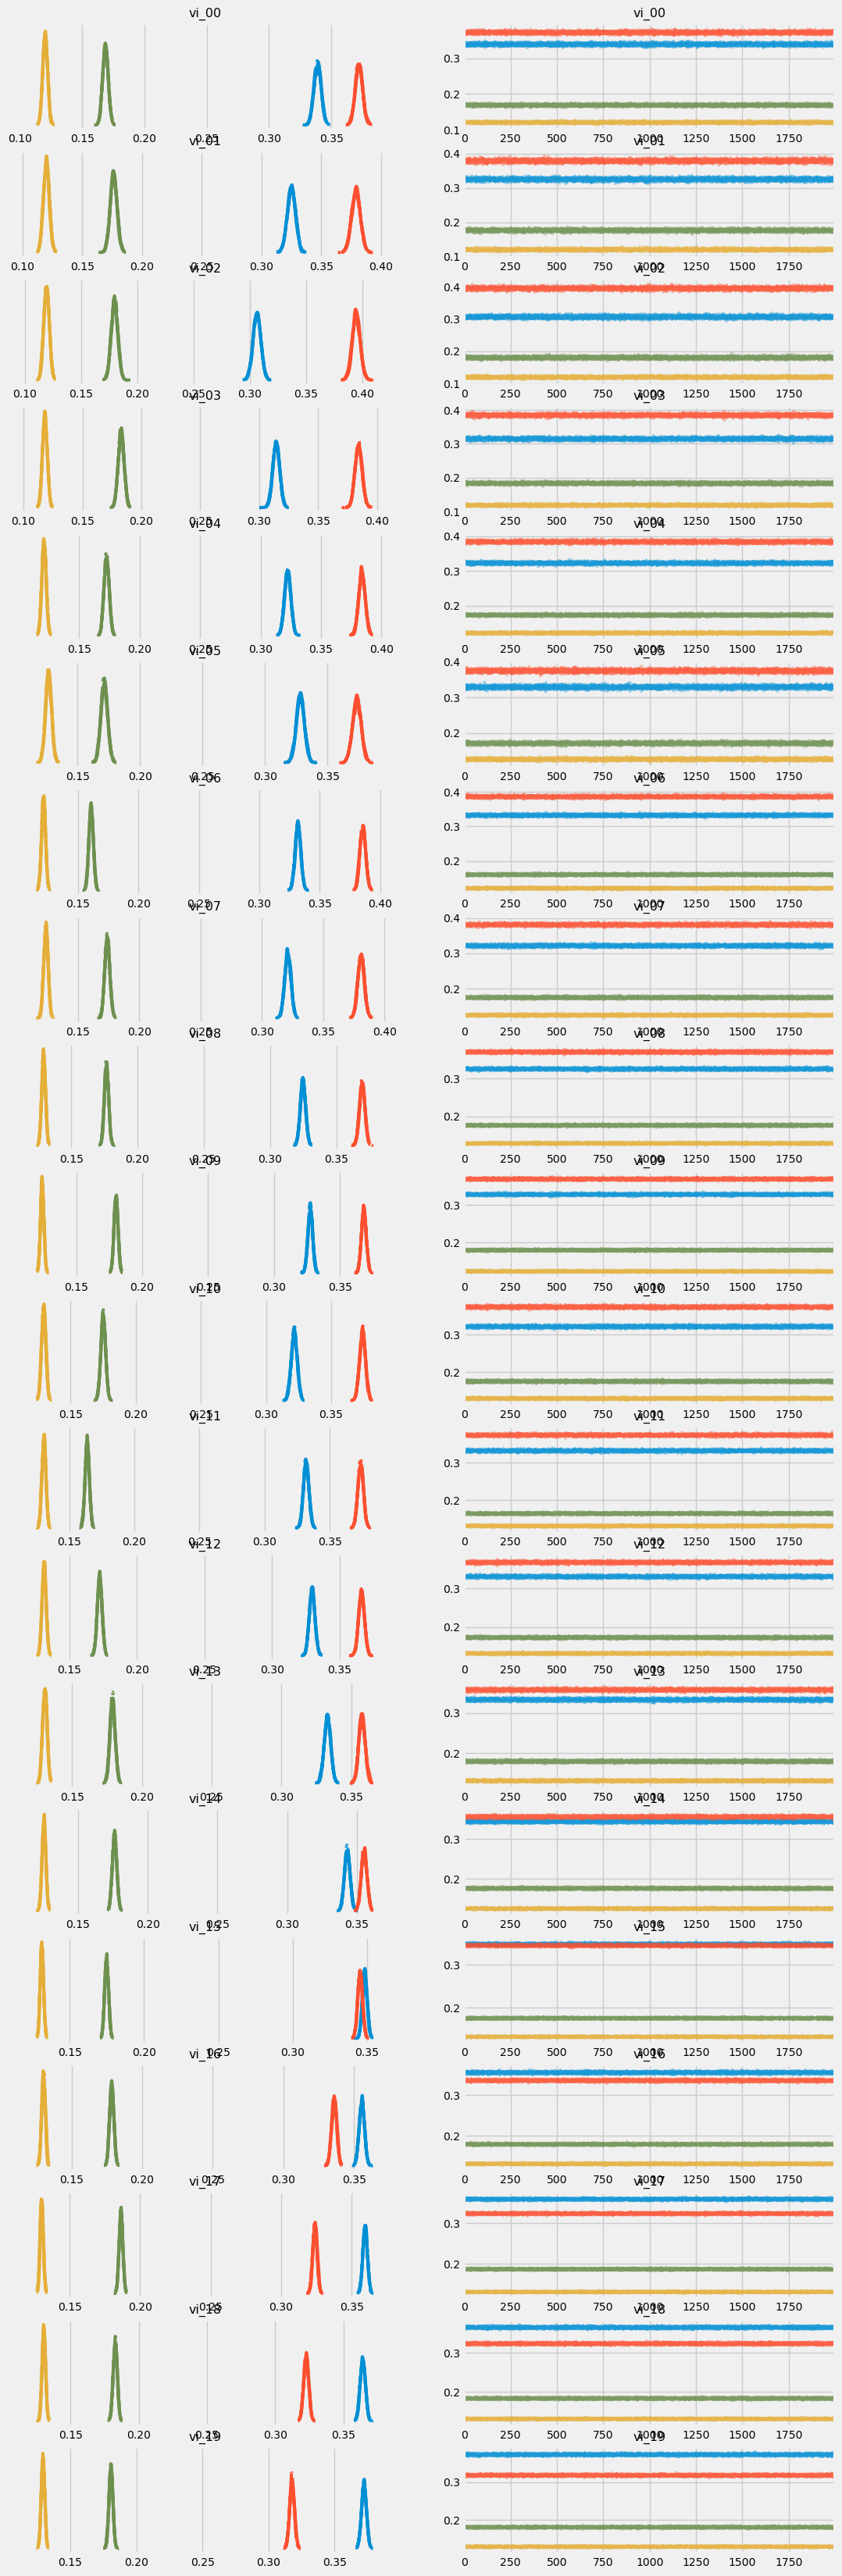

In [8]:
class SampleSettings(TypedDict):
    """The settings for the Bayesian model."""

    draws: int
    tune: int
    cores: int
    chains: int
    nuts_sampler: str
    nuts: NotRequired[dict[str, Any]]  # Requires Python 3.11


def sampler_settings() -> SampleSettings:
    """Return the settings for sampling as a tuple
    of two elements:
    - a dict of settings for the sampling (GRW and GP models)
    - a dict of settings for the sampling (GRWLA model)."""

    core_chains = 5
    settings: SampleSettings = {
        "draws": 2_000,  # number of samples per core
        "tune": 3_000,  # number of tuning steps per core
        "cores": core_chains,
        "chains": core_chains,
        "nuts_sampler": "numpyro",
    }

    return settings


def run_run() -> tuple[az.InferenceData, str]:
    """Fit the data to the model. Return the inference data
    and a string identifying where glitches may have occurred
    in the sampling process."""

    sampling = sampler_settings()
    idata, glitches = bayes_tools.draw_samples(model, **sampling)

    return idata, glitches


run_run()

In [9]:
def graph_model(m: pm.Model, do_it: bool = False) -> None:
    """Graph the model."""

    if not do_it:
        return

    gv = pm.model_to_graphviz(m)
    gv.render(
        format="png",
        filename=(MODEL_DIR + "/dirichlet_vi"),
    )
    display(gv)


graph_model(model)

## Charts

## Finished

In [10]:
print("Finished")

Finished
